COVID/images 文件夹: 找到 3616 张图像
Normal/images 文件夹: 找到 10192 张图像
Viral Pneumonia/images 文件夹: 找到 1345 张图像
Lung_Opacity/images 文件夹: 找到 6012 张图像
总共找到 21165 张图像
Epoch 1/10


100%|██████████| 662/662 [00:55<00:00, 11.85it/s]


Generator Loss: 1.2638781070709229, Discriminator Loss: 0.7578679323196411


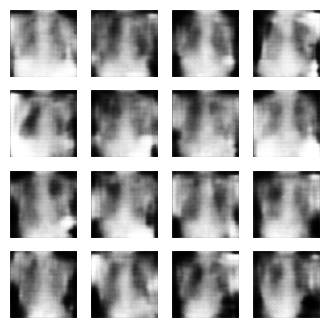

Epoch 2/10


100%|██████████| 662/662 [00:51<00:00, 12.95it/s]


Generator Loss: 1.194756031036377, Discriminator Loss: 1.2000725269317627


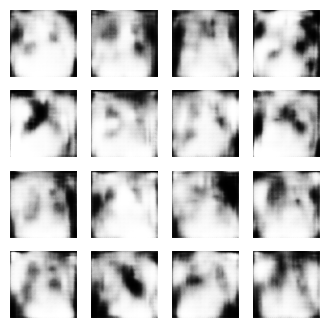

Epoch 3/10


100%|██████████| 662/662 [00:51<00:00, 12.83it/s]


Generator Loss: 0.8288220763206482, Discriminator Loss: 1.1199190616607666


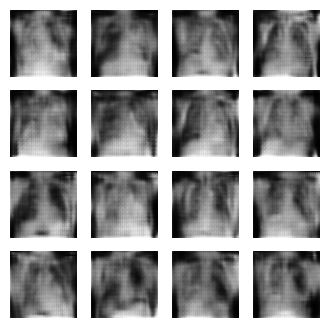

Epoch 4/10


100%|██████████| 662/662 [00:51<00:00, 12.76it/s]


Generator Loss: 1.4467511177062988, Discriminator Loss: 0.7768390774726868


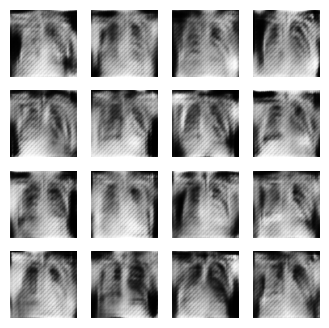

Epoch 5/10


100%|██████████| 662/662 [00:51<00:00, 12.81it/s]


Generator Loss: 0.819206953048706, Discriminator Loss: 1.3305790424346924


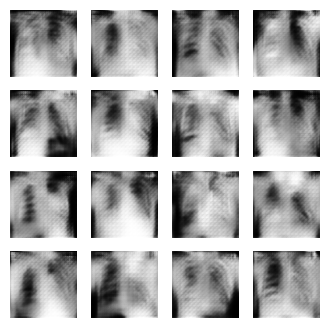

Epoch 6/10


100%|██████████| 662/662 [00:51<00:00, 12.84it/s]


Generator Loss: 0.8817707896232605, Discriminator Loss: 1.3729710578918457


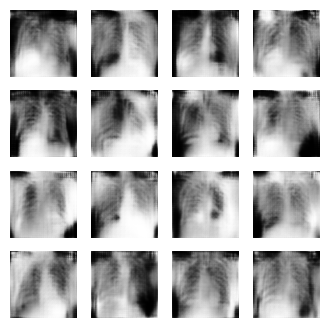

Epoch 7/10


100%|██████████| 662/662 [00:51<00:00, 12.84it/s]


Generator Loss: 0.7626805305480957, Discriminator Loss: 1.5823006629943848


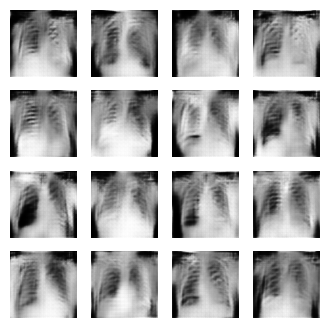

Epoch 8/10


100%|██████████| 662/662 [00:50<00:00, 12.98it/s]


Generator Loss: 0.9673947095870972, Discriminator Loss: 0.8875412940979004


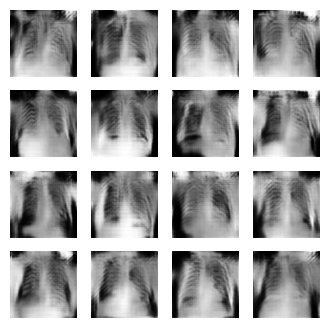

Epoch 9/10


100%|██████████| 662/662 [00:51<00:00, 12.86it/s]


Generator Loss: 1.4142546653747559, Discriminator Loss: 0.8600856065750122


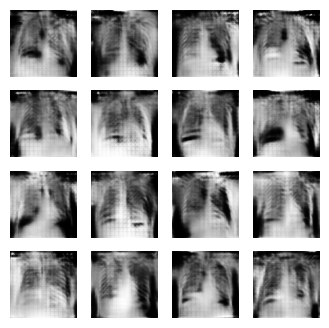

Epoch 10/10


100%|██████████| 662/662 [00:51<00:00, 12.96it/s]


Generator Loss: 0.9276866912841797, Discriminator Loss: 1.0102148056030273


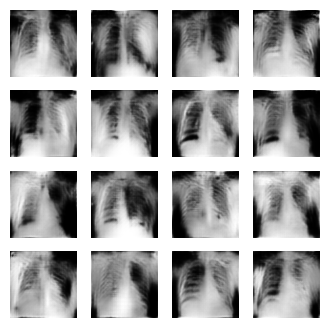

In [2]:
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

data_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

files = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']
all_images = []

for file in files:
    category_folder = os.path.join(data_dir, file, 'images') 
    images = glob(os.path.join(category_folder, '*.png'))
    all_images.extend(images)
    print(f"{file}/images 文件夹: 找到 {len(images)} 张图像")
print(f"总共找到 {len(all_images)} 张图像")

IMG_SIZE = 128

def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image - 127.5) / 127.5  
    return image

dataset = tf.data.Dataset.from_tensor_slices(all_images)
dataset = dataset.map(load_and_preprocess_image).batch(32).shuffle(buffer_size=1024)

def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))  

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))  
    return model

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

EPOCHS =10
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for image_batch in tqdm(dataset):
            gen_loss, disc_loss = train_step(image_batch)

        print(f"Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")

        generate_and_save_images(generator, epoch + 1, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()
    
train(dataset, EPOCHS)
